# 🧠 3D Segmentation - BraTS

## 📦 Imports and Setup

In [1]:
import os
import zipfile
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

## 📥 Data Download

In [2]:
! curl -L -o ~/Downloads/brats20-dataset-training-validation.zip\
  https://www.kaggle.com/api/v1/datasets/download/awsaf49/brats20-dataset-training-validation

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4261M  100 4261M    0     0  31.2M      0  0:02:16  0:02:16 --:--:-- 31.4M


## 🔧 Data Preparation

In [3]:
# Unzip and Rename Files
zip_path = "Downloads/brats20-dataset-training-validation.zip"
extract_dir = "Data/"

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Unzipped successfully!")
else:
    print("Zip file not found.")

old_path = "Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
folder = os.path.basename(os.path.dirname(old_path))
new_filename = f"{folder}_seg.nii"
new_path = os.path.join(os.path.dirname(old_path), new_filename)

if os.path.exists(old_path):
    os.rename(old_path, new_path)
    print(f"Renamed to: {new_path}")
else:
    print("Original file does not exist.")

Unzipped successfully!
Renamed to: Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii


## 📊 Data Loading and Visualization

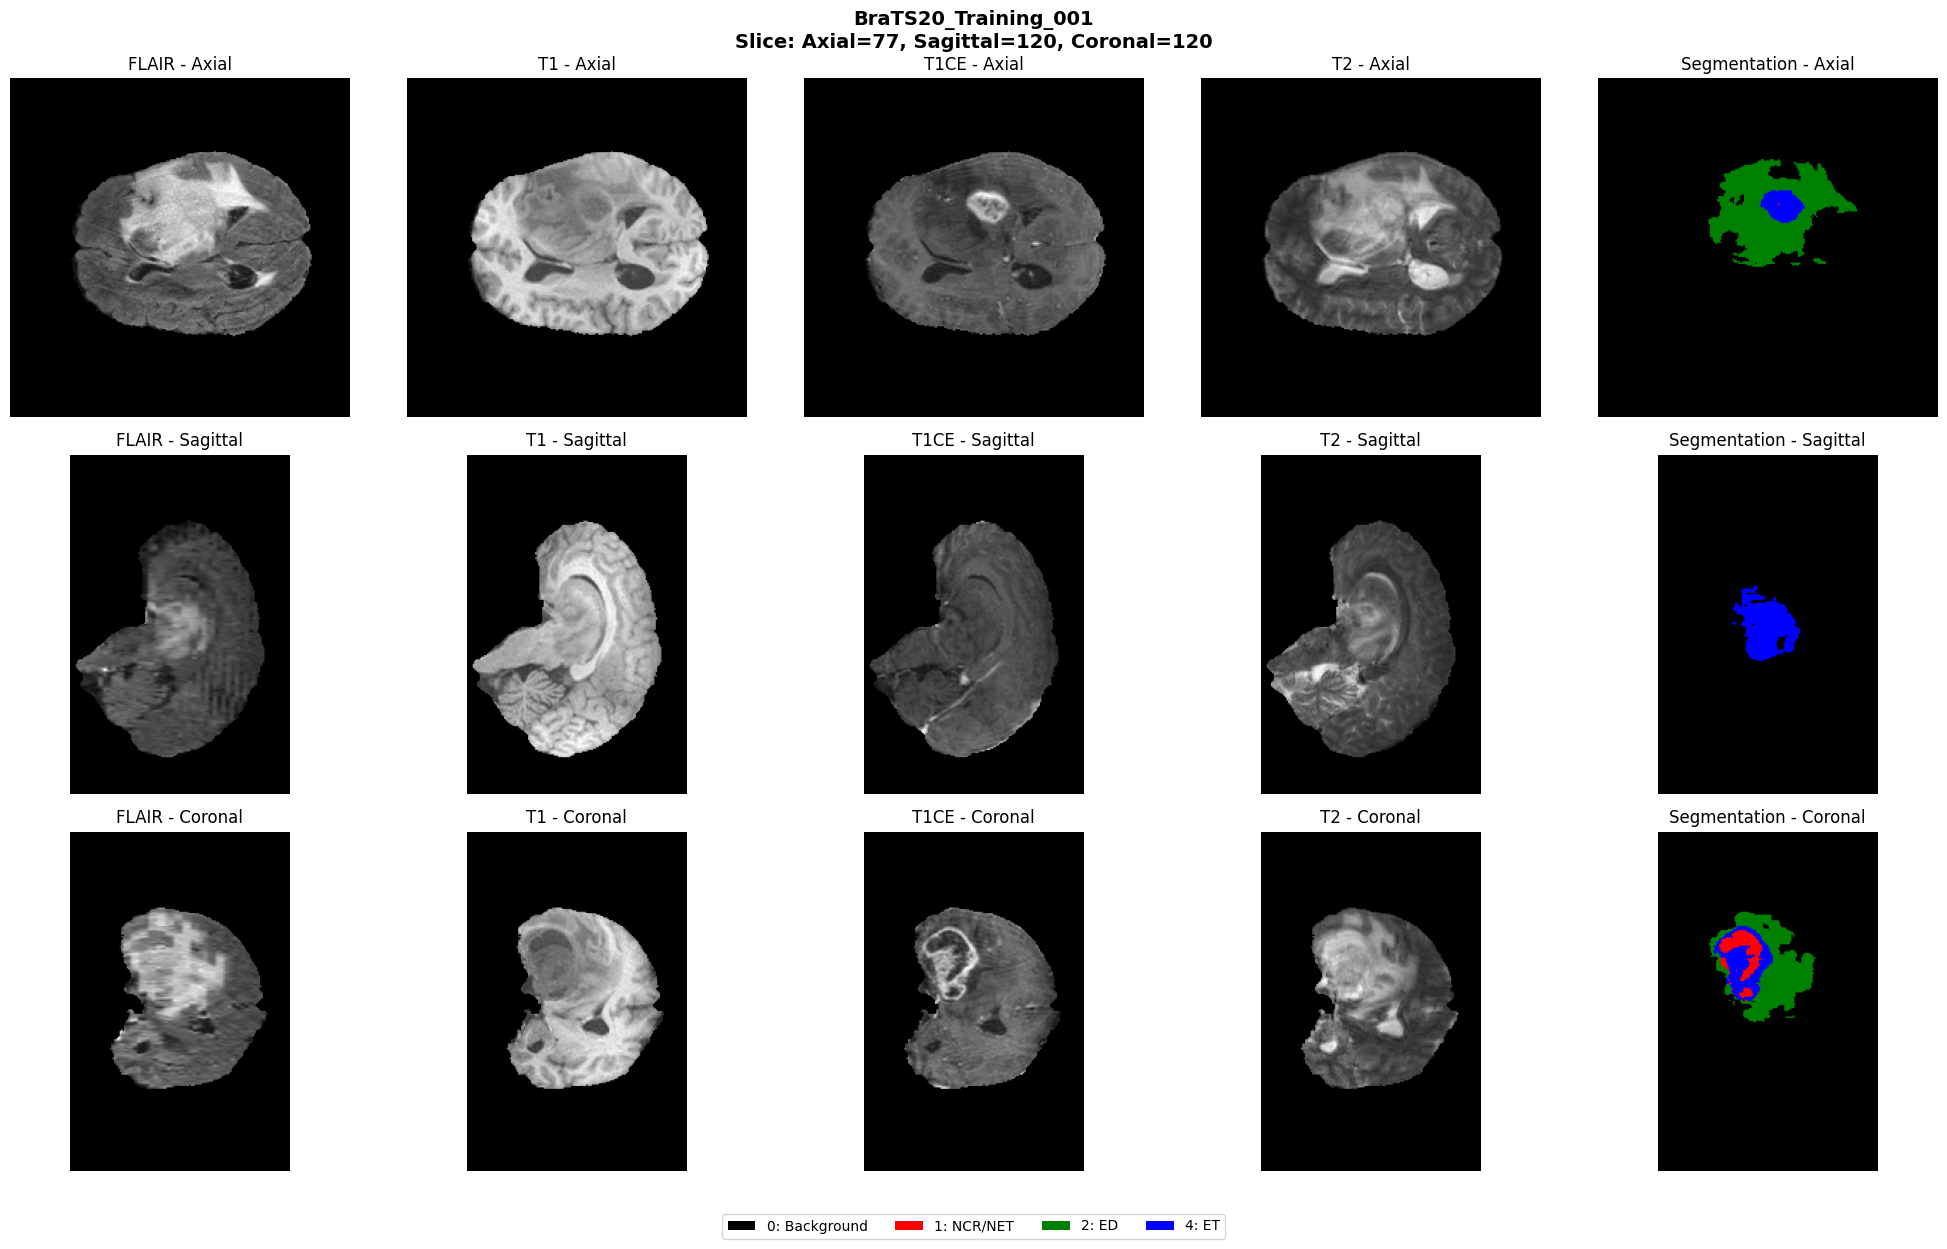

In [4]:
base_path = 'Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/'

flair_img = nib.load(base_path + 'BraTS20_Training_001_flair.nii')
t1_img = nib.load(base_path + 'BraTS20_Training_001_t1.nii')
t1ce_img = nib.load(base_path + 'BraTS20_Training_001_t1ce.nii')
t2_img = nib.load(base_path + 'BraTS20_Training_001_t2.nii')
seg_img = nib.load(base_path + 'BraTS20_Training_001_seg.nii')

flair_data = flair_img.get_fdata()
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
seg_data = seg_img.get_fdata()

axial_slice = flair_data.shape[2] // 2
sagittal_slice = flair_data.shape[0] // 2
coronal_slice = flair_data.shape[1] // 2

seg_colors = {
    0: 'black',   # Background
    1: 'red',     # NCR/NET
    2: 'green',   # ED
    4: 'blue'     # ET
}

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
slice_info = f'Slice: Axial={axial_slice}, Sagittal={sagittal_slice}, Coronal={coronal_slice}'
fig.suptitle(f'BraTS20_Training_001\n{slice_info}', fontsize=14, fontweight='bold')

modalities = [('FLAIR', flair_data), ('T1', t1_data), ('T1CE', t1ce_data), ('T2', t2_data)]
views = [
    ('Axial', lambda data: data[:, :, axial_slice]),
    ('Sagittal', lambda data: data[sagittal_slice, :, :]),
    ('Coronal', lambda data: data[:, coronal_slice, :])
]

for row, (view_name, view_func) in enumerate(views):
    for col, (mod_name, mod_data) in enumerate(modalities):
        axes[row, col].imshow(view_func(mod_data), cmap='gray')
        axes[row, col].set_title(f'{mod_name} - {view_name}')
        axes[row, col].axis('off')
    
    seg_slice = view_func(seg_data)
    colors = ['black', 'red', 'green', 'white', 'blue']
    cmap = ListedColormap(colors)
    axes[row, 4].imshow(seg_slice, cmap=cmap)
    axes[row, 4].set_title(f'Segmentation - {view_name}')
    axes[row, 4].axis('off')

legend_elements = [
    Patch(facecolor='black', label='0: Background'),
    Patch(facecolor='red', label='1: NCR/NET'),
    Patch(facecolor='green', label='2: ED'),
    Patch(facecolor='blue', label='4: ET')
]
fig.legend(handles=legend_elements, loc='lower center', fontsize='medium', ncol=4, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

## 🌐 3D Brain Tumor Visualization

In [5]:
factor = 4
brain = t1ce_data[::factor, ::factor, ::factor]
seg = seg_data[::factor, ::factor, ::factor]

brain_norm = (brain - brain.min()) / (brain.max() - brain.min())

x, y, z = np.mgrid[0:brain.shape[0], 0:brain.shape[1], 0:brain.shape[2]]

fig = go.Figure()

brain_mask = brain_norm > 0.2
coords = np.where(brain_mask)
sample_idx = np.random.choice(len(coords[0]), min(15000, len(coords[0])), replace=False)

fig.add_trace(go.Scatter3d(
    x=coords[0][sample_idx],
    y=coords[1][sample_idx],
    z=coords[2][sample_idx],
    mode='markers',
    marker=dict(size=2, color='lightgray', opacity=0.4),
    name='Brain Tissue'
))

tumor_classes = {
    1: ("NCR/NET", "red", 0.3),    
    2: ("ED", "green", 0.05),      
    4: ("ET", "blue", 0.1)      
}

for lbl, (label_name, color, opacity) in tumor_classes.items():
    coords = np.where(seg == lbl)
    if coords[0].size > 0:
        sample_idx = np.random.choice(len(coords[0]), min(3000, len(coords[0])), replace=False)
        fig.add_trace(go.Scatter3d(
            x=coords[0][sample_idx],
            y=coords[1][sample_idx],
            z=coords[2][sample_idx],
            mode='markers',
            marker=dict(size=4, color=color, opacity=opacity),
            name=label_name
        ))

fig.update_layout(
    title='3D Brain Tumor Segmentation',
    scene=dict(
        xaxis_title='Sagittal',
        yaxis_title='Coronal',
        zaxis_title='Axial',
        aspectmode='data',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0.75, y=0.9,
        bgcolor='rgba(255,255,255,0.6)',
        bordercolor='black',
        borderwidth=1,
        itemsizing='constant',
        font=dict(size=14)
    )
)

fig.show()

## 📚 Dataset and Model References

### 🧠 Brain Tumor Segmentation (BraTS 2020)

**Description:**
The BraTS 2020 dataset provides multi-institutional pre-operative MRI scans for the segmentation of gliomas.
It includes four modalities per subject (T1, T1Gd, T2, FLAIR) and expert-annotated tumor subregions:

* **ET (Enhancing Tumor):** Label 4
* **ED (Peritumoral Edema):** Label 2
* **NCR/NET (Necrotic/Non-Enhancing Tumor Core):** Label 1

**Citations:**

> [1] B. H. Menze *et al.*, "The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)," *IEEE Trans. Med. Imaging*, 34(10):1993–2024, 2015.

> [2] S. Bakas *et al.*, "Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features," *Sci. Data*, 4:170117, 2017.

> [3] S. Bakas *et al.*, "Identifying the Best Machine Learning Algorithms for Brain Tumor Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge," *arXiv preprint* arXiv:1811.02629, 2018.

**Additional Data References:**

> [4] TCGA-GBM (DOI: [10.7937/K9/TCIA.2017.KLXWJJ1Q](https://doi.org/10.7937/K9/TCIA.2017.KLXWJJ1Q))

> [5] TCGA-LGG (DOI: [10.7937/K9/TCIA.2017.GJQ7R0EF](https://doi.org/10.7937/K9/TCIA.2017.GJQ7R0EF))

* 📦 [Dataset (Kaggle)](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation)
* 🌐 [BraTS Challenge](https://www.med.upenn.edu/cbica/brats2020/)

---

### 🧠 Model: SegResNet (3D Brain Tumor Segmentation)

**Description:**
SegResNet is a 3D encoder-decoder segmentation architecture based on residual blocks and deep supervision.

**Citation:**

> A. Myronenko,
> *3D MRI Brain Tumor Segmentation Using Autoencoder Regularization*,
> *arXiv preprint* arXiv:1810.11654, 2018.
> [Paper Link](https://arxiv.org/abs/1810.11654)

* 🧠 Used as backbone in **MONAI’s SegResNet** implementation

* 🧩 Supports 3D volumetric medical imaging

* 🧮 Designed for multi-class tumor region segmentation

* 💻 [MONAI SegResNet Docs](https://docs.monai.io/en/stable/networks.html#segresnet)

---

### ⚙️ Framework: MONAI (Medical Open Network for AI)

**Description:**
**MONAI** is an open-source PyTorch-based framework for developing deep learning models in healthcare imaging.

**Reference:**

> MONAI Consortium. *MONAI: Medical Open Network for AI*, 2020.
> [Website](https://monai.io) | [GitHub](https://github.com/Project-MONAI/MONAI) | [Documentation](https://docs.monai.io)

